# This script is to calculate sensitivity matrices using different time windows and frequency ranges to fit the FOOOF model to the iEEG data and compare the resultign model parameters

In [ ]:
import numpy as np
import mne
import os
import pandas as pd
from pathlib import Path
import scipy
from scipy.stats import pearsonr, spearmanr, kendalltau, normaltest, norm, friedmanchisquare

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.utils.download import load_fooof_data
from fooof.utils.params import compute_knee_frequency

# Plotting functions
import matplotlib.pyplot as plt
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
import imagesc as imagesc

# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns
from plots import plot_annotated_modelx

# hide warnings
import warnings
warnings.filterwarnings("ignore")

## Set time and frequency settings

In [3]:
# Time parametres for broadband analysis
Time_segments = [ 5,  10, 15, 20] # seconds
f_max = [30, 45 , 60, 75] # Hz

# Setting for welch
f_min = 1
fs    = 200
SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean', 'fmin' :f_min }

SETTINGS_F1={'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2={'max_n_peaks':8, 'aperiodic_mode':'fixed'}

## Create matrices for Storage

In [4]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')

# Set dataset
dataset = 'Wakefulness_AllRegions'

# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

W_Kn  = np.zeros([len(regions),16])*np.nan
W_Exp = np.zeros([len(regions),16])*np.nan
W_R2 = np.zeros([len(regions),16])*np.nan
W_ExpF = np.zeros([len(regions),16])*np.nan
W_R2F = np.zeros([len(regions),16])*np.nan

N2_Kn  = np.zeros([len(regions),16])*np.nan
N2_Exp = np.zeros([len(regions),16])*np.nan
N2_R2 = np.zeros([len(regions),16])*np.nan
N2_ExpF = np.zeros([len(regions),16])*np.nan
N2_R2F = np.zeros([len(regions),16])*np.nan

N3_Kn  = np.zeros([len(regions),16])*np.nan
N3_Exp = np.zeros([len(regions),16])*np.nan
N3_R2 = np.zeros([len(regions),16])*np.nan
N3_ExpF = np.zeros([len(regions),16])*np.nan
N3_R2F = np.zeros([len(regions),16])*np.nan

R_Kn  = np.zeros([len(regions),16])*np.nan
R_Exp = np.zeros([len(regions),16])*np.nan
R_R2 = np.zeros([len(regions),16])*np.nan
R_ExpF = np.zeros([len(regions),16])*np.nan
R_R2F = np.zeros([len(regions),16])*np.nan

# FOOOF

## WAKE

In [5]:
i =0 
for C, V in enumerate(regions):
    
    # LOAD DATA
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    
    ii=0    
    for t in Time_segments:
        for f in f_max:

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmax=f, n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            #paramters
            if fm1.has_model:
                W_Kn[i,ii]   = fm1.get_params('aperiodic_params','knee')
                W_Exp[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                W_R2[i,ii]   = fm1.get_params('r_squared')
            else:
                W_Kn[i,ii]   = np.nan
                W_Exp[i,ii]  = np.nan
                W_R2[i,ii]   = np.nan
                
            if fm2.has_model:
                W_ExpF[i,ii] = fm2.get_params('aperiodic_params','exponent')
                W_R2F[i,ii]  = fm2.get_params('r_squared')
            else:
                W_ExpF[i,ii] = np.nan
                W_R2F[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Amygdala_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Angular gyrus_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Eff

## N2

In [6]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N2_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

In [7]:
i =0 
for C, V in enumerate(regions):
    
    # LOAD DATA
    
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    
    ii=0    
    for t in Time_segments:
        for f in f_max:

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmax=f, n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            #paramters
            if fm1.has_model:
                N2_Kn[i,ii]   = fm1.get_params('aperiodic_params','knee')
                N2_Exp[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                N2_R2[i,ii]   = fm1.get_params('r_squared')
            else:
                N2_Kn[i,ii]   = np.nan
                N2_Exp[i,ii]  = np.nan
                N2_R2[i,ii]   = np.nan
                
            if fm2.has_model:
                N2_ExpF[i,ii] = fm2.get_params('aperiodic_params','exponent')
                N2_R2F[i,ii]  = fm2.get_params('r_squared')
            else:
                N2_ExpF[i,ii] = np.nan
                N2_R2F[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N2_AllRegions/Amygdala_N.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N2_AllRegions/Angular gyrus_N.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)


## N3

In [8]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N3_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

In [9]:
i =0 
for C, V in enumerate(regions):
    
    
    # LOAD DATA
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    
    ii=0    
    for t in Time_segments:
        for f in f_max:

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmax=f, n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            #paramters
            if fm1.has_model:
                N3_Kn[i,ii]   = fm1.get_params('aperiodic_params','knee')
                N3_Exp[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                N3_R2[i,ii]   = fm1.get_params('r_squared')
            else:
                N3_Kn[i,ii]   = np.nan
                N3_Exp[i,ii]  = np.nan
                N3_R2[i,ii]   = np.nan
                
            if fm2.has_model:
                N3_ExpF[i,ii] = fm2.get_params('aperiodic_params','exponent')
                N3_R2F[i,ii]  = fm2.get_params('r_squared')
            else:
                N3_ExpF[i,ii] = np.nan
                N3_R2F[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N3_AllRegions/Amygdala_D.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N3_AllRegions/Angular gyrus_D.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)


## REM

In [10]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'REM_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

In [11]:
i =0 
for C, V in enumerate(regions):
    
    
    EEG = mne.io.read_raw_edf(data_path / dataset / V)

    ii=0    
    for t in Time_segments:
        for f in f_max:

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmax=f, n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                 
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            # parameters exctract
            if fm1.has_model:
                R_Kn[i,ii]   = fm1.get_params('aperiodic_params','knee')
                R_Exp[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                R_R2[i,ii]   = fm1.get_params('r_squared')
            else:
                R_Kn[i,ii]   = np.nan
                R_Exp[i,ii]  = np.nan
                R_R2[i,ii]   = np.nan
                
            if fm2.has_model:
                R_ExpF[i,ii] = fm2.get_params('aperiodic_params','exponent')
                R_R2F[i,ii]  = fm2.get_params('r_squared')
            else:
                R_ExpF[i,ii] = np.nan
                R_R2F[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Amygdala_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Angular gyrus_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window si

Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Triangular part of inferior frontal gyrus_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)


# PLOTTING (Knee Model)

## R2 Knee M

In [ ]:
# now we can mean over regions
R2_W = np.nanmean(W_R2,0) R2_N2 = np.nanmean(N2_R2,0) R2_N3 = np.nanmean(N3_R2,0) R2_R = np.nanmean(R_R2,0)

R2_all = np.nanmean([R2_W , R2_N2 , R2_N3 , R2_R], 0)

R2_all_final = np.reshape(R2_all, (4, 4))

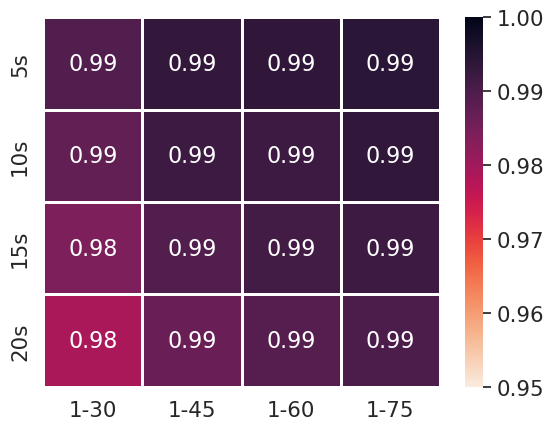

In [13]:
sns.set(font_scale=1.4)

# Now the arrays are ready for plotting 
data_s = pd.DataFrame(R2_all_final,columns=['1-30', '1-45','1-60','1-75'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Broadband_Knee_R2_NewFreqs.svg")

## Exponent Knee M

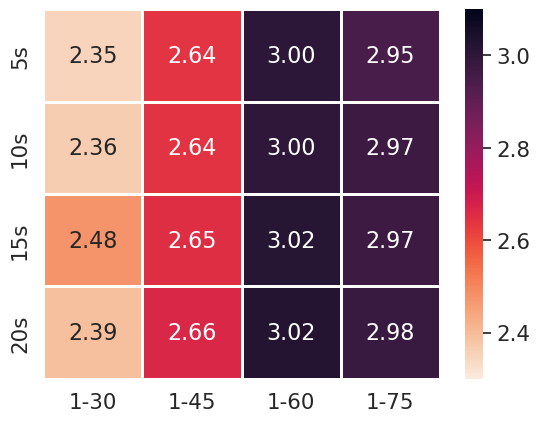

In [14]:
# now we can mean over regions 
E_W = np.nanmean(W_Exp,0)
E_N2 = np.nanmean(N2_Exp,0)
E_N3 = np.nanmean(N3_Exp,0)
E_R = np.nanmean(R_Exp,0)

E_all = np.nanmean([E_W , E_N2 , E_N3 , E_R], 0)

E_all_final = np.reshape(E_all, (4, 4))

# Now the arrays are ready for plotting 
data_s = pd.DataFrame(E_all_final,columns=['1-30', '1-45','1-60','1-75'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=2.3, vmax=3.1)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Broadband_Knee_Exp_NewFreqs.svg")

# Plotting - Fixed M

## R2 _ Fixed

In [15]:
# now we can mean over regions 
R2_W2 = np.nanmean(W_R2F,0)
R2_N22 = np.nanmean(N2_R2F,0)
R2_N32 = np.nanmean(N3_R2F,0)
R2_R2 = np.nanmean(R_R2F,0)

R2_all2 = np.nanmean([R2_W2 , R2_N22 , R2_N32 , R2_R2], 0)

R2_all_final2 = np.reshape(R2_all2, (4, 4))

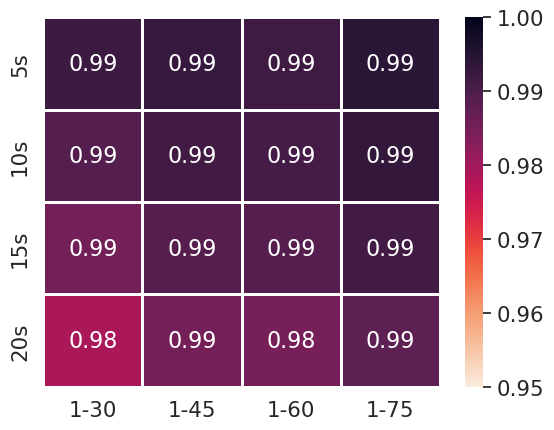

In [16]:
# Now the arrays are ready for plotting 
data_s = pd.DataFrame(R2_all_final2,columns=['1-30', '1-45','1-60','1-75'], index=['5s','10s','15s', '20s'])

sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Broadband_Fixed_R2_NewFreqs.svg")


## Exponent - Fixed M


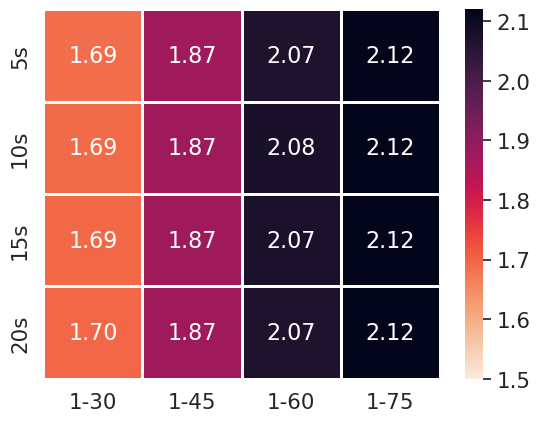

In [17]:
# now we can mean over regions 
E2_W2 = np.nanmean(W_ExpF,0)
E2_N22 = np.nanmean(N2_ExpF,0)
E2_N32 = np.nanmean(N3_ExpF,0)

E2_R2 = np.nanmean(R_ExpF,0)

E2_all2 = np.nanmean([E2_W2 , E2_N22 , E2_N32 , E2_R2], 0)

E2_all_final2 = np.reshape(E2_all2, (4, 4))

# Now the arrays are ready for plotting 
data_s = pd.DataFrame(E2_all_final2,columns=['1-30', '1-45','1-60','1-75'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=1.5, vmax=2.12)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Broadband_Fixed_Exp_NewFreqs.svg")

# Now do the Same for Narrow Frequency bands

## Set paths


In [26]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')

# Set dataset
dataset = 'Wakefulness_AllRegions'

# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

W_KnN  = np.zeros([len(regions),16])*np.nan
W_ExpN = np.zeros([len(regions),16])*np.nan
W_R2N = np.zeros([len(regions),16])*np.nan
W_ExpFN = np.zeros([len(regions),16])*np.nan
W_R2FN = np.zeros([len(regions),16])*np.nan

N2_KnN  = np.zeros([len(regions),16])*np.nan
N2_ExpN = np.zeros([len(regions),16])*np.nan
N2_R2N = np.zeros([len(regions),16])*np.nan
N2_ExpFN = np.zeros([len(regions),16])*np.nan
N2_R2FN = np.zeros([len(regions),16])*np.nan

N3_KnN  = np.zeros([len(regions),16])*np.nan
N3_ExpN = np.zeros([len(regions),16])*np.nan
N3_R2N = np.zeros([len(regions),16])*np.nan
N3_ExpFN = np.zeros([len(regions),16])*np.nan
N3_R2FN = np.zeros([len(regions),16])*np.nan

R_KnN  = np.zeros([len(regions),16])*np.nan
R_ExpN = np.zeros([len(regions),16])*np.nan
R_R2N = np.zeros([len(regions),16])*np.nan
R_ExpFN = np.zeros([len(regions),16])*np.nan
R_R2FN = np.zeros([len(regions),16])*np.nan

## PSD, FOOOF, time and frequency settings

In [27]:
fs    = 200

SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean' }
SETTINGS_F1 = {'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2 = {'max_n_peaks':8, 'aperiodic_mode':'fixed'}

# Time parametres for broadband analysis
Time_segments = [ 5,  10, 15, 20] # seconds
f_min = [1, 1 , 20, 30] # Hz
f_max = [8, 20 , 45, 45] # Hz

# WAKE

In [29]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'Wakefulness_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

i =0 
for C, V in enumerate(regions):
    
    EEG = mne.io.read_raw_edf(data_path / dataset / V)

    ii=0    
    for t in Time_segments:
        for x in np.arange(4):

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmin=f_min[x], fmax=f_max[x], n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
    
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            # parameters exctract
            if fm1.has_model:
                W_KnN[i,ii]   = fm1.get_params('aperiodic_params','knee')
                W_ExpN[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                W_R2N[i,ii]   = fm1.get_params('r_squared')    
            else:
                W_KnN[i,ii]   = np.nan
                W_ExpN[i,ii]  = np.nan
                W_R2N[i,ii]   = np.nan  
            
            if fm2.has_model:
                W_ExpFN[i,ii] = fm2.get_params('aperiodic_params','exponent')
                W_R2FN[i,ii]  = fm2.get_params('r_squared')
            else:
                W_ExpFN[i,ii] = np.nan
                W_R2FN[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Amygdala_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/Wakefulness_AllRegions/Angular gyrus_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Eff

# N2

In [30]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N2_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

#START
i =0 
for C, V in enumerate(regions):
        
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    
    ii=0    
    for t in Time_segments:
        for x in np.arange(4):

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmin = f_min[x], fmax=f_max[x], n_fft=fs*t, n_overlap=fs*t*0.5)

            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            # parameters exctract
            if fm1.has_model:
                N2_KnN[i,ii]   = fm1.get_params('aperiodic_params','knee')
                N2_ExpN[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                N2_R2N[i,ii]   = fm1.get_params('r_squared')
            else:
                N2_KnN[i,ii]   = np.nan
                N2_ExpN[i,ii]  = np.nan
                N2_R2N[i,ii]   = np.nan
                
            if fm2.has_model:
                N2_ExpFN[i,ii] = fm2.get_params('aperiodic_params','exponent')
                N2_R2FN[i,ii]  = fm2.get_params('r_squared')
            else:
                N2_ExpFN[i,ii] = np.nan
                N2_R2FN[i,ii]  = np.nan
                
            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N2_AllRegions/Amygdala_N.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N2_AllRegions/Angular gyrus_N.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size

# N3

In [31]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'N3_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

i =0 
for C, V in enumerate(regions):
    
    # LOAD DATA
    EEG = mne.io.read_raw_edf(data_path / dataset / V)
    
    ii=0    
    for t in Time_segments:
        for x in np.arange(4):

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmin= f_min[x], fmax=f_max[x], n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            #paramters
            if fm1.has_model:
                N3_KnN[i,ii]   = fm1.get_params('aperiodic_params','knee')
                N3_ExpN[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                N3_R2N[i,ii]   = fm1.get_params('r_squared')
            else:
                N3_KnN[i,ii]   = np.nan
                N3_ExpN[i,ii]  = np.nan
                N3_R2N[i,ii]   = np.nan
                
            if fm2.has_model:
                N3_ExpFN[i,ii] = fm2.get_params('aperiodic_params','exponent')
                N3_R2FN[i,ii]  = fm2.get_params('r_squared')
            else:
                N3_ExpFN[i,ii] = np.nan
                N3_R2FN[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N3_AllRegions/Amygdala_D.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/N3_AllRegions/Angular gyrus_D.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size

# R

In [32]:
# Set data path
data_path = Path('/home/b1044271/Columbia/iEEG')
# Set dataset
dataset = 'REM_AllRegions'
# Get list of files, which correspond to regions
regions = np.sort(os.listdir(data_path / dataset))

i =0 
for C, V in enumerate(regions):
    
    EEG = mne.io.read_raw_edf(data_path / dataset / V)

    ii=0    
    for t in Time_segments:
        for x in np.arange(4):

            EEG_psd = EEG.compute_psd(**SETTINGS_W, fmin= f_min[x], fmax=f_max[x], n_fft=fs*t, n_overlap=fs*t*0.5)
    
            fm1 = FOOOF(**SETTINGS_F1)
            fm1.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
                 
            fm2 = FOOOF(**SETTINGS_F2)
            fm2.fit(EEG_psd._freqs, np.mean(EEG_psd._data,0), [EEG_psd._freqs[0] , EEG_psd._freqs[-1]])
            
            # parameters exctract
            if fm1.has_model:
                R_KnN[i,ii]   = fm1.get_params('aperiodic_params','knee')
                R_ExpN[i,ii]  = fm1.get_params('aperiodic_params','exponent')
                R_R2N[i,ii]   = fm1.get_params('r_squared')
            else:
                R_KnN[i,ii]   = np.nan
                R_ExpN[i,ii]  = np.nan
                R_R2N[i,ii]   = np.nan
                
            if fm2.has_model:
                R_ExpFN[i,ii] = fm2.get_params('aperiodic_params','exponent')
                R_R2FN[i,ii]  = fm2.get_params('r_squared')
            else:
                R_ExpFN[i,ii] = np.nan
                R_R2FN[i,ii]  = np.nan

            ii = ii +1
    i = i+1

Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Amygdala_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 10.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 15.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Effective window size : 20.000 (s)
Extracting EDF parameters from /home/b1044271/Columbia/iEEG/REM_AllRegions/Angular gyrus_R.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 5.000 (s)
Effective window size : 5.000 (s)
Effective window si

# PLOTTING - Knee

## R2

In [33]:
# now we can mean over regions 
R2_WN = np.nanmean(W_R2N,0)
R2_N2N = np.nanmean(N2_R2N,0)
R2_N3N = np.nanmean(N3_R2N,0)
R2_RN = np.nanmean(R_R2N,0)

# reorganize matrix
R2_allN = np.nanmean([R2_WN , R2_N2N , R2_N3N , R2_RN], 0)
R2_all_finalN = np.reshape(R2_allN, (4, 4)) 

#plt.figure(figsize=(6, 4))
# Now the arrays are ready for plotting 
data_s = pd.DataFrame(R2_all_finalN,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True,annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)
 
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Narrowband_Knee_R2.svg')

## Exponent

In [ ]:
# now we can mean over regions 
E_WN = np.nanmean(W_ExpN,0)
E_N2N = np.nanmean(N2_ExpN,0)
E_N3N = np.nanmean(N3_ExpN,0)
E_RN = np.nanmean(R_ExpN,0)

E_allN = np.nanmean([E_WN , E_N2N , E_N3N , E_RN], 0)
E_all_finalN = np.reshape(E_allN, (4, 4))

#plt.figure(figsize=(6, 4))
# Now the arrays are ready for plotting 
data_s = pd.DataFrame(E_all_finalN,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=1, vmax=5)

plt.savefig('/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Narrowband_Knee_Exp.svg')

# Statistically Compare Broad and Narrow

## R2 - Normality test

In [50]:
X = scipy.stats.normaltest(np.concatenate((R2_allNF, R2_all2), axis = 0), nan_policy='propagate')
X

NormaltestResult(statistic=16.688695875191364, pvalue=0.00023773642936603687)

## R2 - Wilcoxson test for non-normal data

In [57]:
N= 16
W, p = scipy.stats.wilcoxon(R2_all2, R2_allNF, zero_method='wilcox', alternative='greater') 

r = W / (N * (N + 1) / 2)
r, W, p

(1.0, 136.0, 1.52587890625e-05)

In [52]:
np.mean(R2_all2), np.mean(R2_allNF)

(0.9891136882702249, 0.9451304921035886)

# Plotting - Fixed M

## R2

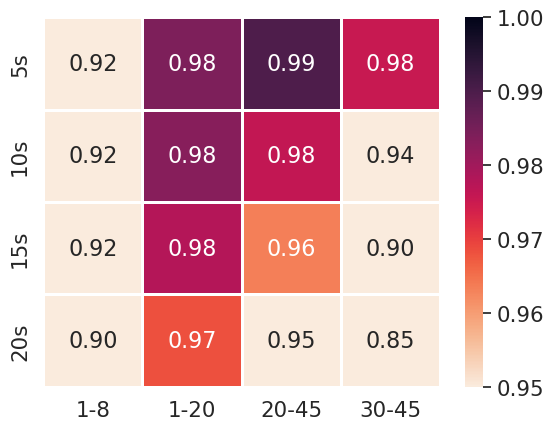

In [36]:
# now we can mean over regions 
R2_WNF = np.nanmean(W_R2FN,0)
R2_N2NF = np.nanmean(N2_R2FN,0)
R2_N3NF = np.nanmean(N3_R2FN,0)
R2_RNF = np.nanmean(R_R2FN,0)

R2_allNF = np.nanmean([R2_WNF , R2_N2NF , R2_N3NF , R2_RNF], 0)

R2_all_finalNF = np.reshape(R2_allNF, (4, 4))

# Now the arrays are ready for plotting 
data_s = pd.DataFrame(R2_all_finalNF,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, annot_kws={"size": 16}, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)

plt.savefig('/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Narrowband_Fixed_R2.svg')

## Exponent

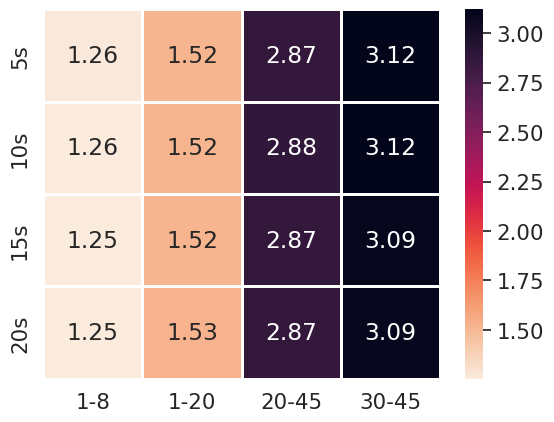

In [37]:
# now we can mean over regions 
E_WNF = np.nanmean(W_ExpFN,0)
E_N2NF = np.nanmean(N2_ExpFN,0)
E_N3NF = np.nanmean(N3_ExpFN,0)
E_RNF = np.nanmean(R_ExpFN,0)

E_allNF = np.nanmean([E_WNF , E_N2NF , E_N3NF , E_RNF], 0)

E_all_finalNF = np.reshape(E_allNF, (4, 4))

# Now the arrays are ready for plotting 
data_s = pd.DataFrame(E_all_finalNF,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)

plt.savefig('/home/b1044271/Columbia/Plots/NOV24/iEEG_Sensitivity_Narrowband_Fixed_Exp.svg')

# COMPARING VARIANCES Broadband vs Narrowband


## R2 variance calculations

In [38]:
# R2
array_list_B = [np.nanstd(W_R2F,0), np.nanstd(N2_R2F,0) , np.nanstd(N3_R2F,0), np.nanstd(R_R2F,0)]
array_list_B2 = np.nanmean(array_list_B,0)

array_list_N = [np.nanstd(W_R2FN,0), np.nanstd(N2_R2FN,0) , np.nanstd(N3_R2FN,0), np.nanstd(R_R2FN,0)]
array_list_N2 = np.nanmean(array_list_N,0)

R2_list = np.hstack([np.hstack(array_list_B2) , np.hstack(array_list_N2)])

# EXPONENT
Exp_list_B = [np.nanstd(W_ExpF,0), np.nanstd(N2_ExpF,0) , np.nanstd(N3_ExpF,0), np.nanstd(R_ExpF,0)]
Exp_list_B2 = np.nanmean(Exp_list_B,0)

Exp_list_N = [np.nanstd(W_ExpFN,0), np.nanstd(N2_ExpFN,0) , np.nanstd(N3_ExpFN,0), np.nanstd(R_ExpFN,0)]
Exp_list_N2 = np.nanmean(Exp_list_N,0)

Exp_list = np.hstack([np.hstack(Exp_list_B2) , np.hstack(Exp_list_N2)])

#####
data = {'R2 variance' : R2_list, 'exponent variance' :Exp_list, 
         'range': np.repeat(['broad','narrow'], 16, axis=0)}


{'R2 variance': array([0.00529189, 0.00439979, 0.00431886, 0.00286907, 0.00708394,
        0.00439731, 0.00409112, 0.00338451, 0.00937347, 0.00611594,
        0.00605857, 0.0048594 , 0.01566669, 0.00907539, 0.00880106,
        0.00762216, 0.0944301 , 0.02493121, 0.00986424, 0.02571661,
        0.07939607, 0.01356845, 0.02091567, 0.05186657, 0.0696222 ,
        0.01555283, 0.03046347, 0.07041063, 0.07465981, 0.02208623,
        0.04248895, 0.0928302 ]),
 'exponent variance': array([0.19892962, 0.16511564, 0.14386685, 0.13762317, 0.20078079,
        0.16654213, 0.14592474, 0.13876253, 0.20076653, 0.16541749,
        0.14679404, 0.13850591, 0.2020988 , 0.1663392 , 0.1474709 ,
        0.1396065 , 0.32746192, 0.23524224, 0.43540043, 0.55157925,
        0.32694747, 0.22317213, 0.44318358, 0.53754628, 0.33142729,
        0.22425572, 0.42903232, 0.53331056, 0.32416323, 0.22624975,
        0.43837571, 0.54533794]),
 'range': array(['broad', 'broad', 'broad', 'broad', 'broad', 'broad', 'broad',


## Plotting

Using Spearman correlation
Correlation: 0.8643695014662756
P-value: 1.8277486871485545e-10


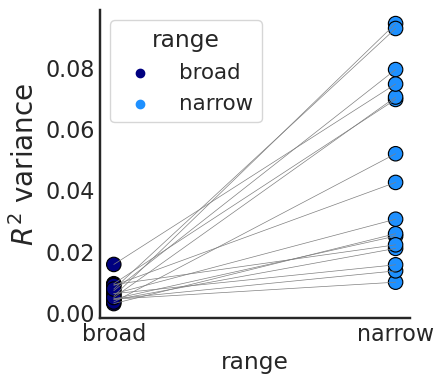

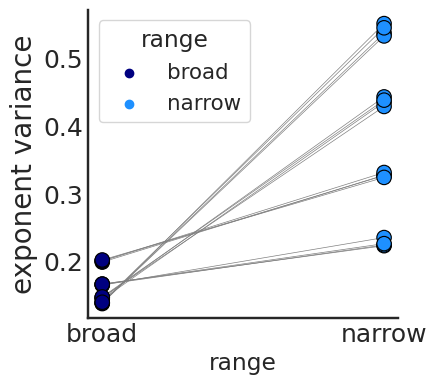

<Figure size 250x250 with 0 Axes>

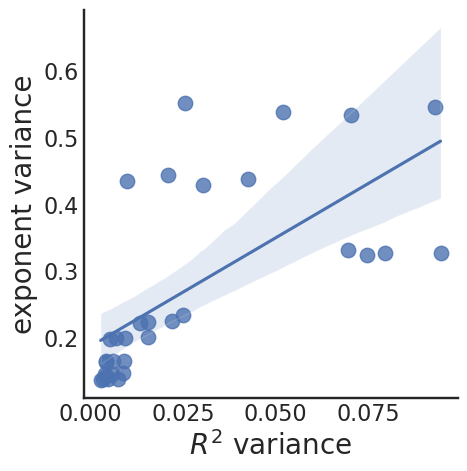

In [51]:
df1 = pd.DataFrame(data)

sns.set_style("white")

ColStage = ['navy', 'dodgerblue']
#####################################################

fig = plt.figure(figsize=(4, 4))  

#sns.relplot(x='range', y='R2 variance',   kind='line',  zorder=4, data=df1,legend=False)
sns.scatterplot(x='range', y='R2 variance',  palette = ColStage, hue = 'range' ,data=df1, s = 108, edgecolor='black')  
plt.plot([R2_list[0:16], R2_list[16:32]], color = 'grey', linewidth = 0.5, linestyle = '-');

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('$R^2$ variance', fontsize=20)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_sensitivity_R2_variance_fixed_NEW.svg")


fig = plt.figure(figsize=(4, 4))  
#sns.relplot(x='range', y='exponent variance', kind='line',  zorder=4, data=df1,legend=False)
sns.scatterplot(x='range', y='exponent variance',   palette = ColStage, hue = 'range', zorder=4, s = 108, data=df1, edgecolor='black')
plt.plot([Exp_list[0:16], Exp_list[16:32]], color = 'grey', linewidth = 0.5, linestyle = '-');

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent variance', fontsize=20)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_sensitivity_Exp_variance_fixed_NEW.svg")

############################################
perform_correlation(R2_list,Exp_list)

fig = plt.figure(figsize=(2.5, 2.5)) 
sns.lmplot(x="R2 variance", y="exponent variance",  data=df1, scatter_kws={"s": 108});
plt.ylabel('exponent variance',fontsize=20)
plt.xlabel('$R^2$ variance', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax= plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/Corr_R2_Exp_Broad_fixed_new.svg")




# Variance Statistics

### Normality test


In [1]:
X = scipy.stats.normaltest(np.concatenate((array_list_B2, array_list_N2), axis = 0), nan_policy='propagate')


NameError: name 'scipy' is not defined

## Test for R2

In [42]:
stat, p = stats.wilcoxon(R2_all2, R2_allNF, alternative= 'greater')
print(f'Wilcoxon Test Statistic: {stat}, p-value: {p}')

# Calculate effect size - Rank-biserial correlation
n = len(array_list_B2)
ranked = stats.rankdata(np.concatenate([R2_all2, R2_allNF]))
rank1 = ranked[:n]
rank2 = ranked[n:]
effect_size = (np.mean(rank1) - np.mean(rank2)) / n

effect_size

Wilcoxon Test Statistic: 136.0, p-value: 1.52587890625e-05


0.921875

## Test for R2 variance

In [43]:
stat, p = stats.wilcoxon(array_list_B2, array_list_N2, alternative='less')
print(f'Wilcoxon Test Statistic: {stat}, p-value: {p}')

# Calculate effect size - Rank-biserial correlation
n = len(array_list_B2)
ranked = stats.rankdata(np.concatenate([array_list_B2, array_list_N2]))
rank1 = ranked[:n]
rank2 = ranked[n:]
effect_size = (np.mean(rank1) - np.mean(rank2)) / n

effect_size

Wilcoxon Test Statistic: 0.0, p-value: 1.52587890625e-05


-0.9765625

## Test for Exp variance

In [44]:
stat, p = stats.wilcoxon(Exp_list_B2, Exp_list_N2, alternative='less')
print(f'Wilcoxon Test Statistic: {stat}, p-value: {p}')

# Calculate effect size - Rank-biserial correlation
n = len(array_list_B2)
ranked = stats.rankdata(np.concatenate([Exp_list_B2, Exp_list_N2]))
rank1 = ranked[:n]
rank2 = ranked[n:]
effect_size = (np.mean(rank1) - np.mean(rank2)) / n

effect_size

Wilcoxon Test Statistic: 0.0, p-value: 1.52587890625e-05


-1.0

Using Spearman correlation
Correlation: 0.8643695014662756
P-value: 1.8277486871485545e-10


<Figure size 400x300 with 0 Axes>

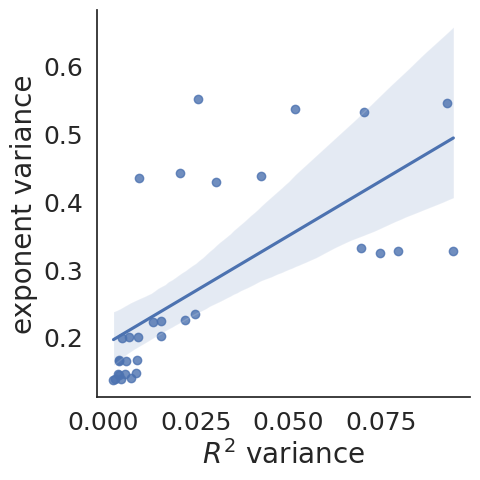

In [46]:
perform_correlation(R2_list,Exp_list)

fig = plt.figure(figsize=(4, 3)) 
sns.lmplot(x="R2 variance", y="exponent variance",  data=df1);
plt.ylabel('exponent variance',fontsize=20)
plt.xlabel('$R^2$ variance', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/Corr_R2_Exp_Broad_fixed_new.svg")


In [47]:
# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers")
from utils import check_distribution, perform_correlation


Using Spearman correlation
Correlation: 0.7385531135531135
P-value: 3.2721916441878334e-12
Using Spearman correlation
Correlation: 0.4464743589743589
P-value: 0.00021732018652282988


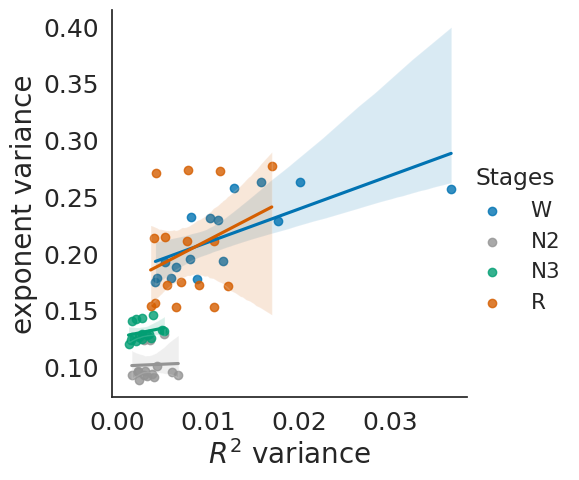

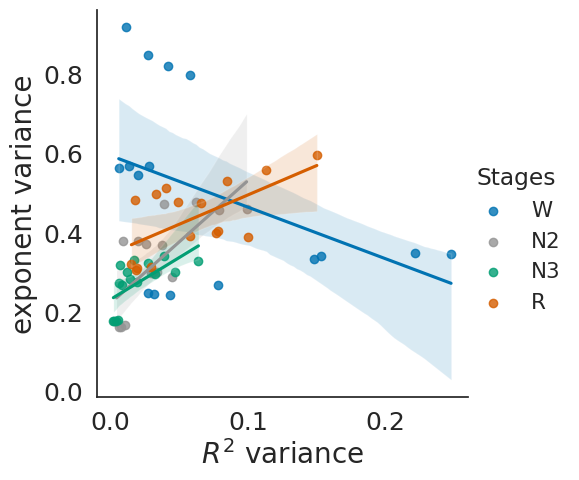

In [49]:
perform_correlation(np.hstack(array_list_B),np.hstack(Exp_list_B))

data = {'R2' : np.hstack(array_list_B),
       'exponent' : np.hstack(Exp_list_B),
       'Stages' : np.repeat(['W','N2','N3','R'], 16, axis=0)}

df2 = pd.DataFrame(data)

ColStage = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[7], 
        sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[3]]

# PLOT correlations 
sns.lmplot(x="R2", y="exponent", hue="Stages", palette = ColStage, data=df2);

plt.ylabel('exponent variance',fontsize=20)
plt.xlabel('$R^2$ variance', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/Corr_R2_Exp_Broad_fixed_new.svg")


##### Narrow
perform_correlation(np.hstack(array_list_N),np.hstack(Exp_list_N))

data = {'R2' : np.hstack(array_list_N),
       'exponent' : np.hstack(Exp_list_N),
       'Stages' : np.repeat(['W','N2','N3','R'], 16, axis=0)}

df2 = pd.DataFrame(data)


# PLOT correlations 
sns.lmplot(x="R2", y="exponent", hue="Stages", palette = ColStage, data=df2);

plt.ylabel('exponent variance',fontsize=20)
plt.xlabel('$R^2$ variance', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/Corr_R2_Exp_Narrow_Fixed.svg")

# Correlation between EXP and R2

Using Spearman correlation
Correlation: 0.4464743589743589
P-value: 0.00021732018652282988


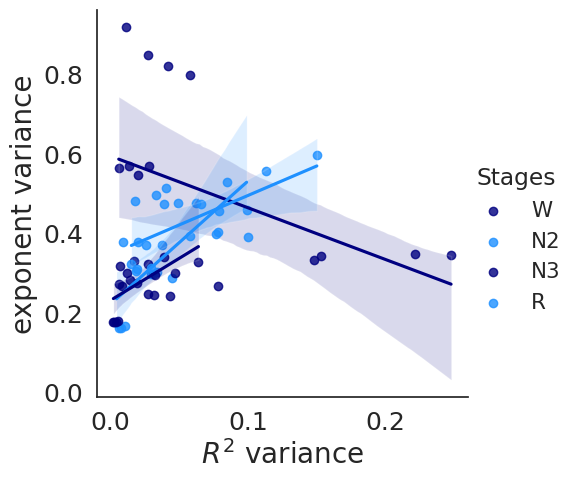

In [60]:
perform_correlation(np.hstack(array_list_N),np.hstack(Exp_list_N))

data = {'R2' : np.hstack(array_list_N),
       'exponent' : np.hstack(Exp_list_N),
       'Stages' : np.repeat(['W','N2','N3','R'], 16, axis=0)}

df2 = pd.DataFrame(data)


# PLOT correlations 
sns.lmplot(x="R2", y="exponent", hue="Stages", palette = ColStage, data=df2);

plt.ylabel('exponent variance',fontsize=20)
plt.xlabel('$R^2$ variance', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)

# Correlations between R2 and Exponent (Revision)

Using Spearman correlation
Correlation: 0.4205882352941176
P-value: 0.10476751392918707
Using Pearson correlation
Correlation: 0.4234929086114475
P-value: 0.1021420182227553
Using Pearson correlation
Correlation: -0.18339829144037167
P-value: 0.49657519951153184
Using Spearman correlation
Correlation: 0.08823529411764705
P-value: 0.7452220943671326


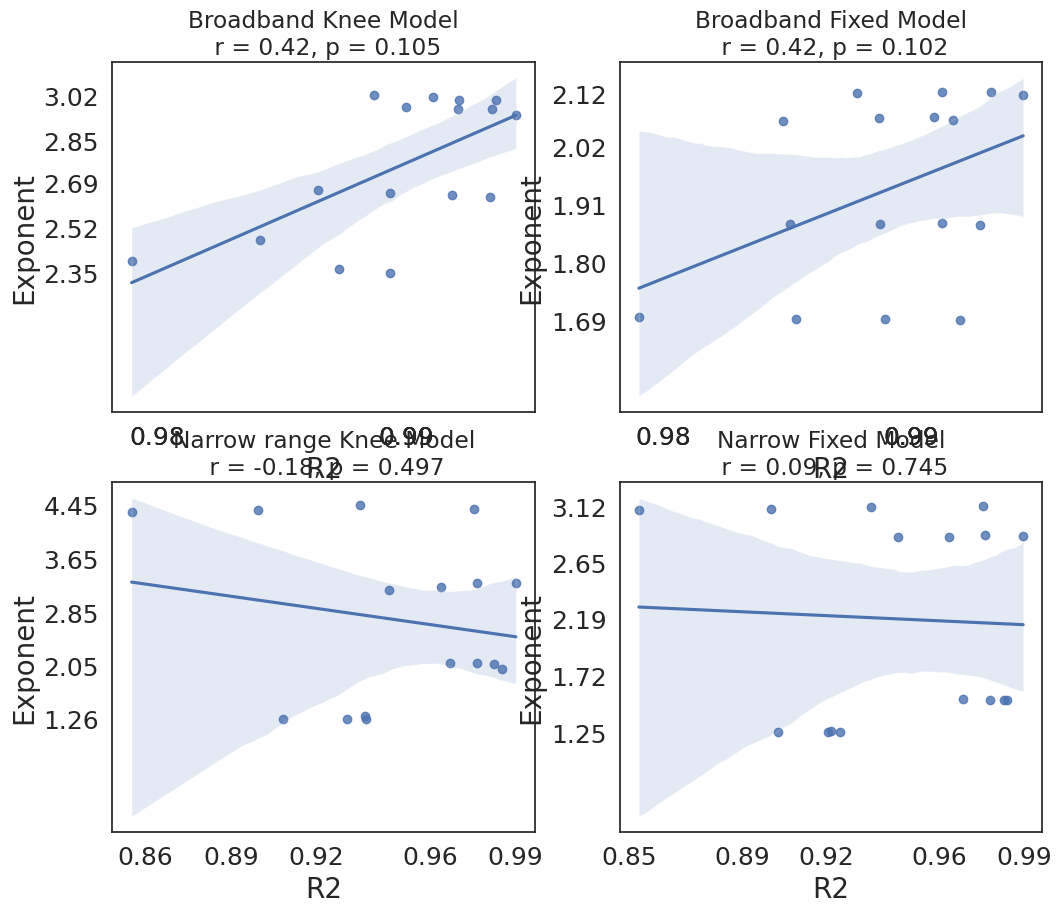

In [89]:

    
# Correlation between exponent and R2 of Broadband Knee Model
corr1 , p1 = perform_correlation(R2_all,E_all)
# Correlation between exponent and R2 of Broadband Fixed Model
corr2, p2 = perform_correlation(R2_all2,E2_all2)
# Correlation between exponent and R2 of Narrow range Knee Model
corr3, p3 = perform_correlation(R2_allN,E_allN)
# Correlation between exponent and R2 of Narrow Fixed Model
corr4, p4 = perform_correlation(R2_allNF,E_allNF)


# Create subplots
plt.figure(figsize=(12, 10))

# Plot 1
plt.subplot(2, 2, 1)
sns.regplot(x=R2_all, y=E_all)
plt.title(f'Broadband Knee Model\n r = {corr1:.2f}, p = {p1:.3f}')
plt.xlabel("R2", fontsize=20)
plt.ylabel("Exponent", fontsize=20)
plt.xticks(ticks=np.round(np.linspace(min(R2_all), max(R2_all), 5), 2), fontsize=18)
plt.yticks(ticks=np.round(np.linspace(min(E_all), max(E_all), 5), 2), fontsize=18)

# Plot 2
plt.subplot(2, 2, 2)
sns.regplot(x=R2_all2, y=E2_all2)
plt.title(f'Broadband Fixed Model\n r = {corr2:.2f}, p = {p2:.3f}')
plt.xlabel("R2", fontsize=20)
plt.ylabel("Exponent", fontsize=20)
plt.xticks(ticks=np.round(np.linspace(min(R2_all2), max(R2_all2), 5), 2), fontsize=18)
plt.yticks(ticks=np.round(np.linspace(min(E2_all2), max(E2_all2), 5), 2), fontsize=18)

# Plot 3
plt.subplot(2, 2, 3)
sns.regplot(x=R2_allN, y=E_allN)
plt.title(f'Narrow range Knee Model\n r = {corr3:.2f}, p = {p3:.3f}')
plt.xlabel("R2", fontsize=20)
plt.ylabel("Exponent", fontsize=20)
plt.xticks(ticks=np.round(np.linspace(min(R2_allN), max(R2_allN), 5), 2), fontsize=18)
plt.yticks(ticks=np.round(np.linspace(min(E_allN), max(E_allN), 5), 2), fontsize=18)

# Plot 4
plt.subplot(2, 2, 4)
sns.regplot(x=R2_allNF, y=E_allNF)
plt.title(f'Narrow Fixed Model\n r = {corr4:.2f}, p = {p4:.3f}')
plt.xlabel("R2", fontsize=20)
plt.ylabel("Exponent", fontsize=20)
plt.xticks(ticks=np.round(np.linspace(min(R2_allNF), max(R2_allNF), 5), 2), fontsize=18)
plt.yticks(ticks=np.round(np.linspace(min(E_allNF), max(E_allNF), 5), 2), fontsize=18)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/Corr_All_exp_r2.svg")